In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
train=pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

In [3]:
numeric_cols_train = train.select_dtypes(include=np.number).columns
medians_train = train[numeric_cols_train].median()
train[numeric_cols_train] = train[numeric_cols_train].fillna(medians_train)
numeric_cols_test = test.select_dtypes(include=np.number).columns
medians_test = test[numeric_cols_test].median()
test[numeric_cols_test] = test[numeric_cols_test].fillna(medians_test)

In [4]:
le=LabelEncoder()
train['Stage_fear']=le.fit_transform(train['Stage_fear'])
train['Personality']=le.fit_transform(train['Personality'])
train['Drained_after_socializing']=le.fit_transform(train['Drained_after_socializing'])
test['Stage_fear']=le.fit_transform(test['Stage_fear'])
test['Drained_after_socializing']=le.fit_transform(test['Drained_after_socializing'])


In [5]:
train_cleaned = train.drop(columns=['id'])
train_cleaned

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,0,6.0,4.0,0,15.0,5.0,0
1,1.0,0,7.0,3.0,0,10.0,8.0,0
2,6.0,1,1.0,0.0,2,3.0,0.0,1
3,3.0,0,7.0,3.0,0,11.0,5.0,0
4,1.0,0,4.0,4.0,0,13.0,5.0,0
...,...,...,...,...,...,...,...,...
18519,3.0,0,7.0,3.0,0,9.0,7.0,0
18520,1.0,2,6.0,7.0,0,6.0,5.0,0
18521,7.0,1,1.0,1.0,1,1.0,5.0,1
18522,2.0,1,1.0,0.0,1,5.0,2.0,1


In [6]:
from sklearn.model_selection import train_test_split
y=train['Personality']
x=train.drop('Personality',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.24)

In [7]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV 
from sklearn.metrics import f1_score, make_scorer
import json
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer,accuracy_score
from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer,accuracy_score
from xgboost import XGBClassifier


In [8]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 450),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 2.4, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 7),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.001, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": 0.6,
        "verbosity": 0,
        "random_state": 42,
        "use_label_encoder": False,
        "objective": "binary:logistic",
        "eval_metric": "error"
    }
    model = XGBClassifier(**param)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=280,timeout=3600)
optuna.samplers.TPESampler(multivariate=True, group=True)
pruner = optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=5)


[I 2025-07-14 16:16:34,477] A new study created in memory with name: no-name-4e0752f9-311b-4614-b43c-97a222b528d1
[I 2025-07-14 16:16:35,216] Trial 0 finished with value: 0.9649122807017544 and parameters: {'n_estimators': 203, 'learning_rate': 0.291134983341699, 'max_depth': 7, 'reg_lambda': 0.012809142642370189, 'reg_alpha': 0.0013252212163341142, 'colsample_bytree': 0.6094693000356932}. Best is trial 0 with value: 0.9649122807017544.
[I 2025-07-14 16:16:35,512] Trial 1 finished with value: 0.9628879892037787 and parameters: {'n_estimators': 385, 'learning_rate': 0.7349890063132563, 'max_depth': 3, 'reg_lambda': 0.04307325702286811, 'reg_alpha': 0.6498441340013968, 'colsample_bytree': 0.701608870337924}. Best is trial 0 with value: 0.9649122807017544.
[I 2025-07-14 16:16:35,733] Trial 2 finished with value: 0.9511920827710302 and parameters: {'n_estimators': 167, 'learning_rate': 0.757220947144087, 'max_depth': 6, 'reg_lambda': 0.06874333684665605, 'reg_alpha': 0.0038115661815172463,

In [9]:
best_params = study.best_params
best_params

{'n_estimators': 228,
 'learning_rate': 0.019682432356160393,
 'max_depth': 2,
 'reg_lambda': 0.41697140672558264,
 'reg_alpha': 0.5750151331201389,
 'colsample_bytree': 0.5731026111813804}

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
final_model = XGBClassifier(
    **best_params,
    subsample=0.6,
    objective="binary:logistic",
    eval_metric="error",
    verbosity=1,           
    random_state=42,
    use_label_encoder=False
)

print("\n🚀 Model is launching... Training in progress:\n")
final_model.fit(x_train, y_train)

y_pred_final = final_model.predict(x_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n✅ Final accuracy score: {final_accuracy:.4f}")




🚀 Model is launching... Training in progress:


✅ Final accuracy score: 0.9703


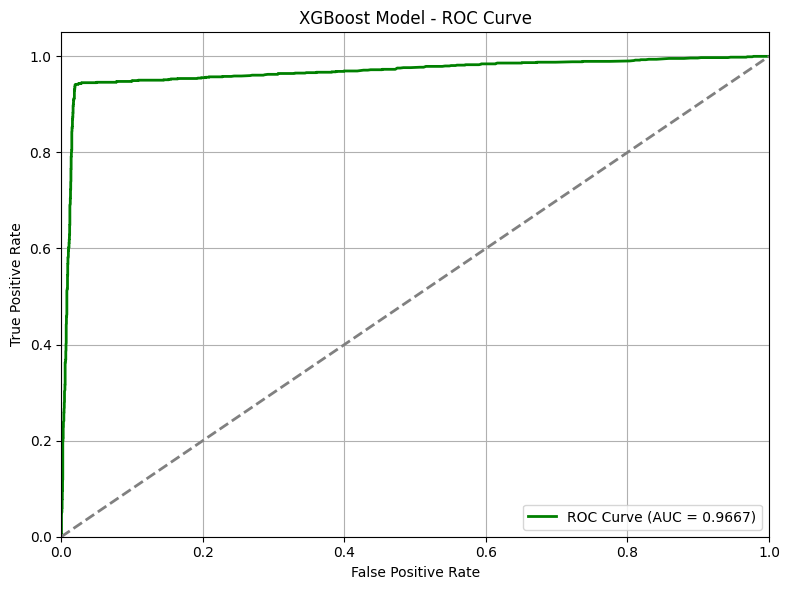

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_proba = final_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Model - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


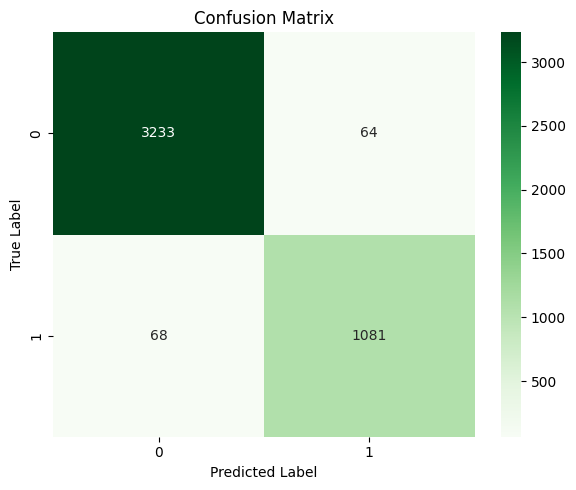

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')  
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [13]:
prediction=final_model.predict(test)
prediction

array([0, 1, 0, ..., 0, 0, 1])

In [14]:
mapping_dict = {0: 'Extrovert', 1: 'Introvert'}
prediction_string = np.array([mapping_dict[val] for val in prediction])
prediction_string


array(['Extrovert', 'Introvert', 'Extrovert', ..., 'Extrovert',
       'Extrovert', 'Introvert'], dtype='<U9')

In [15]:
submission=pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
submission['id']=test['id']
submission['Personality']=prediction_string
submission.to_csv('submission.csv',index=False)
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
